In [1]:
!pip -q install numpy pandas scikit-learn matplotlib tensorflow==2.*

In [ ]:
import os, math, json, random
import numpy as np
import pandas as pd
from collections import Counter


import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)



In [3]:
DATA_DIR = './heartbeat'

In [23]:
def load_csv_pair(train_csv, test_csv):
    train_path = os.path.join(DATA_DIR, train_csv)
    test_path = os.path.join(DATA_DIR, test_csv)
    if not os.path.exists(train_path) or not os.path.exists(test_path):
        raise FileNotFoundError(f'Missing {train_path} or {test_path}. Check DATA_DIR and file names.')

    train = pd.read_csv(train_path, header=None)
    test = pd.read_csv(test_path, header=None)

    X_train = train.iloc[:, :-1].values.astype('float32')
    y_train = train.iloc[:, -1].values.astype('int64')
    X_test  = test.iloc[:, :-1].values.astype('float32')
    y_test  = test.iloc[:, -1].values.astype('int64')

    return X_train, y_train, X_test, y_test

def standardize_per_example(X):
    # z-score per row to reduce amplitude variation
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-6
    return (X - mu) / sd

def to_cnn_input(X):
    # CNN expects (N, L, C). Here C=1 (single lead after preprocessing). L=187
    return X[..., None]

def class_weights_from_labels(y):
    # Inverse frequency weighting
    counts = Counter(y)
    total = sum(counts.values())
    return {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}

In [24]:
TASK = 'mitbih'  # 'mitbih' or 'ptbdb'

if TASK == 'mitbih':
    train_csv, test_csv = 'mitbih_train.csv', 'mitbih_test.csv'
    n_classes = 5
elif TASK == 'ptbdb':
    train_csv, test_csv = 'ptbdb_train.csv', 'ptbdb_test.csv'
    n_classes = 2
else:
    raise ValueError("TASK must be 'mitbih' or 'ptbdb'")

X_train, y_train, X_test, y_test = load_csv_pair(train_csv, test_csv)
print('Train shape:', X_train.shape, ' Test shape:', X_test.shape)
print('Train label distribution:', Counter(y_train))
print('Test  label distribution:', Counter(y_test))

# Standardize and split off a validation set from train
X_train = standardize_per_example(X_train)
X_test  = standardize_per_example(X_test)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=SEED, stratify=y_train
)

X_train_cnn = to_cnn_input(X_train)
X_val_cnn   = to_cnn_input(X_val)
X_test_cnn  = to_cnn_input(X_test)

print('CNN input shapes:', X_train_cnn.shape, X_val_cnn.shape, X_test_cnn.shape)

cls_weights = class_weights_from_labels(y_train)
print('Class weights (inverse freq):', cls_weights)

Train shape: (87554, 187)  Test shape: (21892, 187)
Train label distribution: Counter({np.int64(0): 72471, np.int64(4): 6431, np.int64(2): 5788, np.int64(1): 2223, np.int64(3): 641})
Test  label distribution: Counter({np.int64(0): 18118, np.int64(4): 1608, np.int64(2): 1448, np.int64(1): 556, np.int64(3): 162})
CNN input shapes: (74420, 187, 1) (13134, 187, 1) (21892, 187, 1)
Class weights (inverse freq): {np.int64(0): 0.24162337662337663, np.int64(1): 7.879301217575437, np.int64(2): 3.0252032520325205, np.int64(4): 2.7230150018294914, np.int64(3): 27.310091743119266}


In [25]:
def build_cnn(input_length=187, n_classes=5):
    inp = keras.Input(shape=(input_length, 1))

    x = layers.Conv1D(32, 7, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(128, 5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    if n_classes == 2:
        out = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    else:
        out = layers.Dense(n_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=loss, metrics=metrics)
    return model

model = build_cnn(n_classes=n_classes)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 187, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 187, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 93, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 93, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,701 (272.27 KB)

 Trainable params: 69,253 (270.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    keras.callbacks.ModelCheckpoint('best_heartbeat_cnn.keras', save_best_only=True, monitor='val_loss')
]

history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=256,
    class_weight=cls_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9225 - loss: 0.1431 - val_accuracy: 0.8508 - val_loss: 0.4201
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9303 - loss: 0.1279 - val_accuracy: 0.9420 - val_loss: 0.1685
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9323 - loss: 0.1149 - val_accuracy: 0.9377 - val_loss: 0.1820
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.9333 - loss: 0.1146 - val_accuracy: 0.8971 - val_loss: 0.2854
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9338 - loss: 0.1080 - val_accuracy: 0.8978 - val_loss: 0.2887
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.9437 - loss: 0.0931 - val_accuracy: 0.9040 - val_loss: 0.2598
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.9444 - loss: 0.0909 - val_accuracy: 0.8961 - val_loss: 0.3044
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9435 - loss: 0.0935 - 

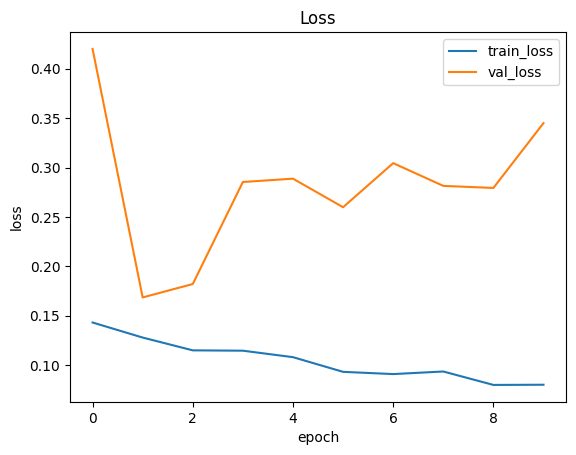

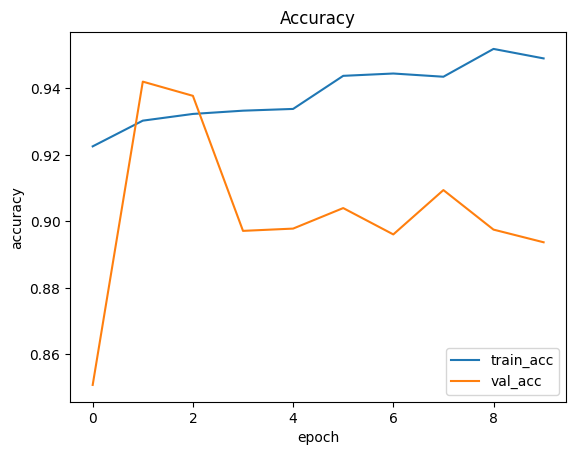

In [28]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss'); plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Accuracy'); plt.show()

In [29]:
def evaluate_model(model, X, y, n_classes):
    # predictions
    if n_classes == 2:
        prob = model.predict(X, verbose=0).ravel()
        pred = (prob >= 0.5).astype(int)
    else:
        prob = model.predict(X, verbose=0)
        pred = prob.argmax(axis=1)

    acc = accuracy_score(y, pred)
    f1m = f1_score(y, pred, average='macro')
    cm  = confusion_matrix(y, pred)

    # AUC (one-vs-rest for multi-class)
    try:
        if n_classes == 2:
            auc = roc_auc_score(y, prob)
        else:
            y_onehot = keras.utils.to_categorical(y, num_classes=n_classes)
            auc = roc_auc_score(y_onehot, prob, average='macro', multi_class='ovr')
    except Exception as e:
        auc = float('nan')
        print('AUC computation issue:', e)

    return acc, f1m, auc, cm, prob, pred

acc, f1m, auc, cm, prob_test, pred_test = evaluate_model(model, X_test_cnn, y_test, n_classes)
print(f'Test Accuracy: {acc:.4f}\nMacro F1: {f1m:.4f}\nROC-AUC: {auc:.4f}\n')
print('Confusion Matrix:\n', cm)

Test Accuracy: 0.9403
Macro F1: 0.7653
ROC-AUC: 0.9886

Confusion Matrix:
 [[17035   480   147   426    30]
 [  111   421    17     6     1]
 [   28     5  1387    25     3]
 [    4     0    12   146     0]
 [    5     3     4     1  1595]]


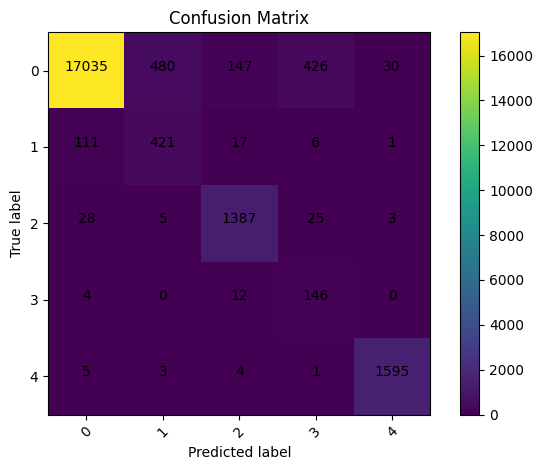

In [30]:
def plot_cm(cm, classes):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout(); plt.show()

classes = list(range(n_classes)) if n_classes>2 else [0,1]
plot_cm(cm, classes)

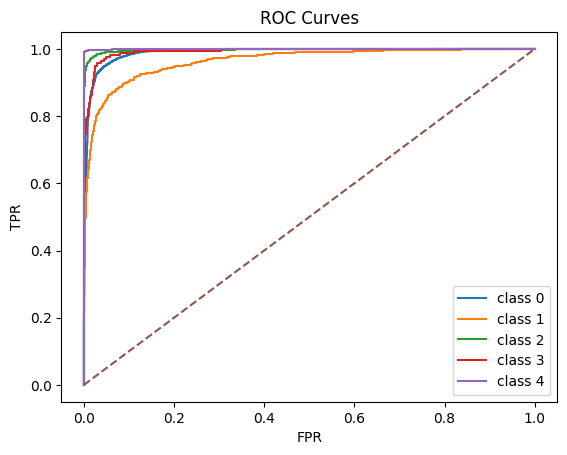

In [31]:
def plot_roc_curves(y_true, prob, n_classes):
    plt.figure()
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, prob)
        plt.plot(fpr, tpr, label='class 1')
    else:
        y_onehot = keras.utils.to_categorical(y_true, num_classes=n_classes)
        for k in range(n_classes):
            fpr, tpr, _ = roc_curve(y_onehot[:,k], prob[:,k])
            plt.plot(fpr, tpr, label=f'class {k}')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.show()

plot_roc_curves(y_test, prob_test, n_classes)

In [32]:
def predict_proba(row_187):
    """Pass a 1D array with 187 samples (a processed heartbeat).
    Returns:
      - Binary task: float (probability of class 1)
      - Multi-class: dict[class_id -> probability]
    """
    x = np.asarray(row_187, dtype='float32')
    assert x.shape[0] == 187, 'Expected 187 features for a heartbeat.'
    # standardize like training
    mu, sd = x.mean(), x.std() + 1e-6
    x = (x - mu)/sd
    x = x[None, :, None]
    p = model.predict(x, verbose=0)
    if n_classes == 2:
        return float(p.ravel()[0])
    else:
        p = p.ravel()
        return {int(k): float(v) for k, v in enumerate(p)}

# Example (first test row):
example_prob = predict_proba(X_test[0])
example_prob

{0: 0.9972322583198547,
 1: 0.0027522474993020296,
 2: 6.702244803591384e-08,
 3: 1.5390860426123254e-05,
 4: 4.94784324622799e-10}

In [33]:
model.save('heartbeat_cnn_final.keras')
print('Saved heartbeat_cnn_final.keras')

Saved heartbeat_cnn_final.keras
